In this Project, we will use a keras Long Short-Term Memory (LSTM) model to predict the stock price of S&P500 ETF


Here are some imports we need to make: numpy for scientific computation, matplotlib for graphing, and pandas for manipulating data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from pathlib import Path

from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [2]:
#####Functions

def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

Load training data set with the "Open" column to use in our modeling.

In [3]:
spy07_df = pd.read_csv(
    Path("spy_hist_07.csv"),
    index_col="date",
    parse_dates=True,
    infer_datetime_format=True
)


####Variables####
window_size = 5
feature_column = 4
target_column = 4

#Make the rolling window data
X, y = window_data(spy07_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")


X sample values:
[[148.53 149.12 149.72 150.77 150.92]
 [149.12 149.72 150.77 150.92 150.49]
 [149.72 150.77 150.92 150.49 150.59]
 [150.77 150.92 150.49 150.59 150.83]
 [150.92 150.49 150.59 150.83 149.68]] 

y sample values:
[[150.49]
 [150.59]
 [150.83]
 [149.68]
 [150.83]]


In [4]:
####To avoid the dataset being randomized, we will manually split the data using array slicing.###
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

Import MinMaxScaler from scikit-learn to scale our dataset into numbers between 0 and 1 

In [5]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [6]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Make the necessary imports from keras

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense 

Add LSTM layer along with dropout layers to prevent overfitting. After that, we add a Dense layer that specifies a one unit output. Next, we compile the model using the adam optimizer and set the loss as the mean_squarred_error

In [8]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X_train,y_train,epochs=20,batch_size=1)

2022-04-13 18:51:05.833610: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
824/824 [==============================] - 6s 4ms/step - loss: 0.0347
Epoch 2/20
824/824 [==============================] - 3s 4ms/step - loss: 0.0138
Epoch 3/20
824/824 [==============================] - 3s 3ms/step - loss: 0.0089
Epoch 4/20
824/824 [==============================] - 3s 4ms/step - loss: 0.0073
Epoch 5/20
824/824 [==============================] - 3s 4ms/step - loss: 0.0057
Epoch 6/20
824/824 [==============================] - 3s 4ms/step - loss: 0.0051
Epoch 7/20
824/824 [==============================] - 3s 4ms/step - loss: 0.0046
Epoch 8/20
824/824 [==============================] - 3s 4ms/step - loss: 0.0044
Epoch 9/20
824/824 [==============================] - 3s 4ms/step - loss: 0.0047
Epoch 10/20
824/824 [==============================] - 3s 4ms/step - loss: 0.0042
Epoch 11/20
824/824 [==============================] - 3s 4ms/step - loss: 0.0043
Epoch 12/20
824/824 [==============================] - 3s 4ms/step - loss: 0.0043
Epoch 13/20
824/824 [====

In [9]:
###Evaluate the model to determine Mean Squared Error for the Test Set in 2007###

In [10]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 1s 2ms/step - loss: 8.2863e-04


0.0008286306983791292

In [11]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

Plot our predicted stock prices and the actual stock price

In [12]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = spy07_df.index[-len(real_prices): ])
stocks

,Real,Predicted
date,,
2010-08-10,112.03,111.584206
2010-08-11,110.65,111.528282
2010-08-12,107.65,111.324738
2010-08-13,108.29,110.818024
2010-08-16,107.57,110.127457
...,...,...
2011-12-23,125.67,122.554291
2011-12-27,126.17,123.169968
2011-12-28,126.51,124.080780


<AxesSubplot:xlabel='date'>

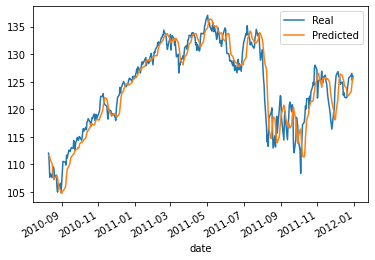

In [13]:
stocks.plot()

### 2017 to 2022 S&P Model Predictions ####

In [14]:
#Produce a dataframe of the 5 year history of the S&P 500 since 2022
spy20_df = pd.read_csv(
    Path("spy_hist_20.csv"),
    index_col="date",
    parse_dates=True,
    infer_datetime_format=True
)


####Variables####
window_size = 5
feature_column = 1
target_column = 1

#Make the rolling window data
X, y = window_data(spy20_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

###New Test Data for 2017 to 2022###
X_test = X
y_test = y

X sample values:
[[225.24 226.58 226.4  227.21 226.46]
 [226.58 226.4  227.21 226.46 226.46]
 [226.4  227.21 226.46 226.46 227.1 ]
 [227.21 226.46 226.46 227.1  226.53]
 [226.46 226.46 227.1  226.53 227.05]] 

y sample values:
[[226.46]
 [227.1 ]
 [226.53]
 [227.05]
 [226.25]]


In [15]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_test)

# Scale the features training and testing sets
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_test)

# Scale the target training and testing sets
y_test = scaler.transform(y_test)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [16]:
model.evaluate(X_test, y_test)

40/40 [==============================] - 0s 2ms/step - loss: 6.2128e-04


0.0006212791777215898

In [17]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [18]:
predict_stocks_2022 = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = spy20_df.index[-len(real_prices): ])
predict_stocks_2022.to_csv('predict_stocks_2022.csv', index=True, header=True)